[참고 문헌]  
[Train a Vision Transformer on small datasets](https://keras.io/examples/vision/vit_small_ds/)

* TensorFlow install
> [TensorFlow가 뭔가요?](https://keras.io/examples/vision/vit_small_ds/)

# 구현에 필요한 라이브러리 설정하기

In [2]:
pip install -qq -U tensorflow-addons

     |████████████████████████████████| 1.1 MB 5.4 MB/s 


In [3]:
import tensorflow as tf
import tensorflow_addons as tfa
train,test = tf.keras.datasets.mnist.load_data()
x_train, y_train = train
x_train = x_train[..., tf.newaxis] / 255.0

# TFA layers and activations
model = tf.keras.Sequential([
  tf.keras.layers.Conv2D(filters=10, kernel_size=(3,3),
                         activation=tfa.activations.gelu),
  tfa.layers.GroupNormalization(groups=5, axis=3),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(10, activation='softmax')
])

# TFA optimizers, losses and metrics
model.compile(
    optimizer=tfa.optimizers.RectifiedAdam(0.001),
    loss=tfa.losses.TripletSemiHardLoss(),
    metrics=[tfa.metrics.MultiLabelConfusionMatrix(num_classes=10)])

history = model.fit(x_train, y_train, epochs=10)

11501568/11490434 [==============================] - 0s 0us/step
Epoch 1/10
1875/1875 [==============================] - 33s 6ms/step - loss: 0.6431 - Multilabel_confusion_matrix: 26613.6504
Epoch 2/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.4480 - Multilabel_confusion_matrix: 26134.1992
Epoch 3/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.3568 - Multilabel_confusion_matrix: 25993.4004
Epoch 4/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.3167 - Multilabel_confusion_matrix: 25955.7246
Epoch 5/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.2374 - Multilabel_confusion_matrix: 25898.8750
Epoch 6/10
1875/1875 [==============================] - 12s 6ms/step - loss: 0.1902 - Multilabel_confusion_matrix: 25862.1758
Epoch 7/10
1875/1875 [==============================] - 11s 6ms/step - loss: 0.1735 - Multilabel_confusion_matrix: 25836.1992
Epoch 8/10
1875/1875 [==============================]

## 설정

In [4]:
import math
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
from tensorflow.keras import layers

# Setting seed for reproducibiltiy
SEED = 42
keras.utils.set_random_seed(SEED)

## 데이터 준비

In [5]:
NUM_CLASSES = 100
INPUT_SHAPE = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

169017344/169001437 [==============================] - 2s 0us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


## 초매개변수(hyperparameters) 구성하기

In [6]:
# DATA
BUFFER_SIZE = 512
BATCH_SIZE = 256

# AUGMENTATION
IMAGE_SIZE = 72
PATCH_SIZE = 6
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2

# OPTIMIZER
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001

# TRAINING
EPOCHS = 50

# ARCHITECTURE
LAYER_NORM_EPS = 1e-6
TRANSFORMER_LAYERS = 8
PROJECTION_DIM = 64
NUM_HEADS = 4
TRANSFORMER_UNITS = [
    PROJECTION_DIM * 2,
    PROJECTION_DIM,
]
MLP_HEAD_UNITS = [2048, 1024]

## 데이터 증강 사용

In [7]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

## 시프트 패치 토큰화 구현

ViT 파이프라인에서 입력 이미지는 패치로 분할된 다음 선형으로 토큰으로 투영됩니다. ViT의 낮은 수용 영역을 방지하기 위해 STP(Shifted Patch Tokenization)가 도입되었습니다. 시프트 패치 토큰화 단계는 다음과 같습니다.
* 이미지로 시작하세요.
* 이미지를 대각선 방향으로 이동합니다.
* 대각선으로 이동된 이미지를 원본 이미지와 연결합니다.
* 연결된 이미지의 패치를 추출합니다.
* 모든 패치의 공간 차원을 평평하게 합니다.
* 레이어는 평평한 패치를 정규화한 다음 투영합니다.

| ![Shifted Patch Toekenization](https://i.imgur.com/bUnHxd0.png) |
| :--: |
| Shifted Patch Tokenization [Source](https://arxiv.org/abs/2112.13492v1) |

In [8]:
class ShiftedPatchTokenization(layers.Layer):
    def __init__(
        self,
        image_size=IMAGE_SIZE,
        patch_size=PATCH_SIZE,
        num_patches=NUM_PATCHES,
        projection_dim=PROJECTION_DIM,
        vanilla=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.vanilla = vanilla  # Flag to swtich to vanilla patch extractor
        self.image_size = image_size
        self.patch_size = patch_size
        self.half_patch = patch_size // 2
        self.flatten_patches = layers.Reshape((num_patches, -1))
        self.projection = layers.Dense(units=projection_dim)
        self.layer_norm = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)

    def crop_shift_pad(self, images, mode):
        # Build the diagonally shifted images
        if mode == "left-up":
            crop_height = self.half_patch
            crop_width = self.half_patch
            shift_height = 0
            shift_width = 0
        elif mode == "left-down":
            crop_height = 0
            crop_width = self.half_patch
            shift_height = self.half_patch
            shift_width = 0
        elif mode == "right-up":
            crop_height = self.half_patch
            crop_width = 0
            shift_height = 0
            shift_width = self.half_patch
        else:
            crop_height = 0
            crop_width = 0
            shift_height = self.half_patch
            shift_width = self.half_patch

        # Crop the shifted images and pad them
        crop = tf.image.crop_to_bounding_box(
            images,
            offset_height=crop_height,
            offset_width=crop_width,
            target_height=self.image_size - self.half_patch,
            target_width=self.image_size - self.half_patch,
        )
        shift_pad = tf.image.pad_to_bounding_box(
            crop,
            offset_height=shift_height,
            offset_width=shift_width,
            target_height=self.image_size,
            target_width=self.image_size,
        )
        return shift_pad

    def call(self, images):
        if not self.vanilla:
            # Concat the shifted images with the original image
            images = tf.concat(
                [
                    images,
                    self.crop_shift_pad(images, mode="left-up"),
                    self.crop_shift_pad(images, mode="left-down"),
                    self.crop_shift_pad(images, mode="right-up"),
                    self.crop_shift_pad(images, mode="right-down"),
                ],
                axis=-1,
            )
        # Patchify the images and flatten it
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        flat_patches = self.flatten_patches(patches)
        if not self.vanilla:
            # Layer normalize the flat patches and linearly project it
            tokens = self.layer_norm(flat_patches)
            tokens = self.projection(tokens)
        else:
            # Linearly project the flat patches
            tokens = self.projection(flat_patches)
        return (tokens, patches)

## 패치 시각화

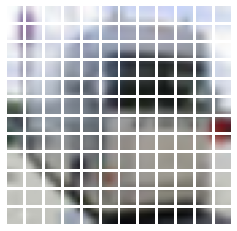

ORIGINAL


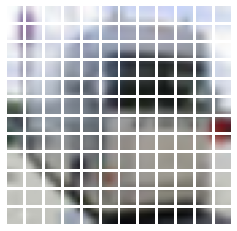

LEFT-UP


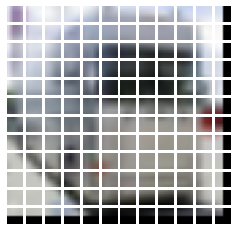

LEFT-DOWN


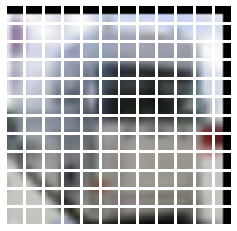

RIGHT-UP


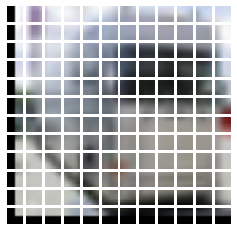

RIGHT-DOWN


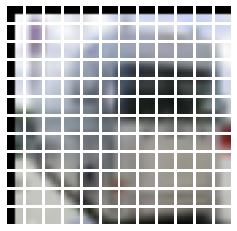

In [9]:
# Get a random image from the training dataset
# and resize the image
image = x_train[np.random.choice(range(x_train.shape[0]))]
resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(IMAGE_SIZE, IMAGE_SIZE)
)

# Vanilla patch maker: This takes an image and divides into
# patches as in the original ViT paper
(token, patch) = ShiftedPatchTokenization(vanilla=True)(resized_image / 255.0)
(token, patch) = (token[0], patch[0])
n = patch.shape[0]
count = 1
plt.figure(figsize=(4, 4))
for row in range(n):
    for col in range(n):
        plt.subplot(n, n, count)
        count = count + 1
        image = tf.reshape(patch[row][col], (PATCH_SIZE, PATCH_SIZE, 3))
        plt.imshow(image)
        plt.axis("off")
plt.show()

# Shifted Patch Tokenization: This layer takes the image, shifts it
# diagonally and then extracts patches from the concatinated images
(token, patch) = ShiftedPatchTokenization(vanilla=False)(resized_image / 255.0)
(token, patch) = (token[0], patch[0])
n = patch.shape[0]
shifted_images = ["ORIGINAL", "LEFT-UP", "LEFT-DOWN", "RIGHT-UP", "RIGHT-DOWN"]
for index, name in enumerate(shifted_images):
    print(name)
    count = 1
    plt.figure(figsize=(4, 4))
    for row in range(n):
        for col in range(n):
            plt.subplot(n, n, count)
            count = count + 1
            image = tf.reshape(patch[row][col], (PATCH_SIZE, PATCH_SIZE, 5 * 3))
            plt.imshow(image[..., 3 * index : 3 * index + 3])
            plt.axis("off")
    plt.show()

## 패치 인코딩 계층 구현

이 레이어는 투영된 패치를 받아들인 다음 위치 정보를 추가합니다.

In [10]:
class PatchEncoder(layers.Layer):
    def __init__(
        self, num_patches=NUM_PATCHES, projection_dim=PROJECTION_DIM, **kwargs
    ):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
        self.positions = tf.range(start=0, limit=self.num_patches, delta=1)

    def call(self, encoded_patches):
        encoded_positions = self.position_embedding(self.positions)
        encoded_patches = encoded_patches + encoded_positions
        return encoded_patches

## 지역 자기 주의 구현

일반 주의 방정식은 다음과 같습니다.  

| ![Equation of attention](https://miro.medium.com/max/396/1*P9sV1xXM10t943bXy_G9yg.png) |
| :--: |
| [Source](https://towardsdatascience.com/attention-is-all-you-need-discovering-the-transformer-paper-73e5ff5e0634) |

주의 모듈은 쿼리, 키 및 값을 사용합니다. 먼저 내적을 통해 쿼리와 키 간의 유사성을 계산합니다. 그런 다음 결과는 키 차원의 제곱근으로 조정됩니다. 스케일링은 softmax 함수가 지나치게 작은 기울기를 갖는 것을 방지합니다. 그런 다음 Softmax를 스케일된 내적에 적용하여 주의 가중치를 생성합니다. 그런 다음 값은 주의 가중치를 통해 변조됩니다.

셀프 어텐션에서는 쿼리, 키 및 값이 동일한 입력에서 나옵니다. 내적은 토큰 간 관계보다 큰 자체 토큰 관계를 생성합니다. 이는 또한 softmax가 토큰 간 관계보다 자체 토큰 관계에 더 높은 확률을 제공한다는 것을 의미합니다. 이를 방지하기 위해 저자는 내적의 대각선을 마스킹할 것을 제안합니다. 이런 식으로 우리는 Attention 모듈이 토큰 간 관계에 더 많은 관심을 기울이도록 합니다.

스케일링 팩터는 regular Attention 모듈에서 상수입니다. 이것은 softmax 기능을 조절할 수 있는 온도 항처럼 작동합니다. 저자는 상수 대신 학습 가능한 온도 항을 제안합니다.  

| ![Implementation of LSA](https://i.imgur.com/GTV99pk.png) |
| :--: |
| Locality Self Attention [Source](https://arxiv.org/abs/2112.13492v1) |  

위의 두 포인터는 Locality Self Attention을 만듭니다. [`layers.MultiHeadAttention`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention) 훈련 가능한 온도 를 하위 분류 하고 구현했습니다. 주의 마스크는 나중 단계에서 만들어집니다.

In [11]:
class MultiHeadAttentionLSA(tf.keras.layers.MultiHeadAttention):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # The trainable temperature term. The initial value is
        # the square root of the key dimension.
        self.tau = tf.Variable(math.sqrt(float(self._key_dim)), trainable=True)

    def _compute_attention(self, query, key, value, attention_mask=None, training=None):
        query = tf.multiply(query, 1.0 / self.tau)
        attention_scores = tf.einsum(self._dot_product_equation, key, query)
        attention_scores = self._masked_softmax(attention_scores, attention_mask)
        attention_scores_dropout = self._dropout_layer(
            attention_scores, training=training
        )
        attention_output = tf.einsum(
            self._combine_equation, attention_scores_dropout, value
        )
        return attention_output, attention_scores

## MLP 구현

In [12]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


# Build the diagonal attention mask
diag_attn_mask = 1 - tf.eye(NUM_PATCHES)
diag_attn_mask = tf.cast([diag_attn_mask], dtype=tf.int8)

## ViT 구축

In [13]:
def create_vit_classifier(vanilla=False):
    inputs = layers.Input(shape=INPUT_SHAPE)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    (tokens, _) = ShiftedPatchTokenization(vanilla=vanilla)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder()(tokens)

    # Create multiple layers of the Transformer block.
    for _ in range(TRANSFORMER_LAYERS):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        if not vanilla:
            attention_output = MultiHeadAttentionLSA(
                num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
            )(x1, x1, attention_mask=diag_attn_mask)
        else:
            attention_output = layers.MultiHeadAttention(
                num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
            )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=TRANSFORMER_UNITS, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=MLP_HEAD_UNITS, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(NUM_CLASSES)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

## 모드 컴파일, 훈련 및 평가

In [14]:
# Some code is taken from:
# https://www.kaggle.com/ashusma/training-rfcx-tensorflow-tpu-effnet-b2.
class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super(WarmUpCosine, self).__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")

        cos_annealed_lr = tf.cos(
            self.pi
            * (tf.cast(step, tf.float32) - self.warmup_steps)
            / float(self.total_steps - self.warmup_steps)
        )
        learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )


def run_experiment(model):
    total_steps = int((len(x_train) / BATCH_SIZE) * EPOCHS)
    warmup_epoch_percentage = 0.10
    warmup_steps = int(total_steps * warmup_epoch_percentage)
    scheduled_lrs = WarmUpCosine(
        learning_rate_base=LEARNING_RATE,
        total_steps=total_steps,
        warmup_learning_rate=0.0,
        warmup_steps=warmup_steps,
    )

    optimizer = tfa.optimizers.AdamW(
        learning_rate=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        validation_split=0.1,
    )
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history


# Run experiments with the vanilla ViT
vit = create_vit_classifier(vanilla=True)
history = run_experiment(vit)

# Run experiments with the Shifted Patch Tokenization and
# Locality Self Attention modified ViT
vit_sl = create_vit_classifier(vanilla=False)
history = run_experiment(vit_sl)

Epoch 1/50
176/176 [==============================] - 80s 397ms/step - loss: 4.4911 - accuracy: 0.0427 - top-5-accuracy: 0.1542 - val_loss: 3.9287 - val_accuracy: 0.1008 - val_top-5-accuracy: 0.2986
Epoch 2/50
176/176 [==============================] - 68s 387ms/step - loss: 3.9830 - accuracy: 0.0902 - top-5-accuracy: 0.2777 - val_loss: 3.6454 - val_accuracy: 0.1414 - val_top-5-accuracy: 0.3908
Epoch 3/50
176/176 [==============================] - 68s 388ms/step - loss: 3.7336 - accuracy: 0.1235 - top-5-accuracy: 0.3529 - val_loss: 3.3616 - val_accuracy: 0.1882 - val_top-5-accuracy: 0.4598
Epoch 4/50
176/176 [==============================] - 68s 388ms/step - loss: 3.5702 - accuracy: 0.1506 - top-5-accuracy: 0.4004 - val_loss: 3.2422 - val_accuracy: 0.2168 - val_top-5-accuracy: 0.5104
Epoch 5/50
176/176 [==============================] - 68s 388ms/step - loss: 3.4345 - accuracy: 0.1771 - top-5-accuracy: 0.4392 - val_loss: 3.1057 - val_accuracy: 0.2414 - val_top-5-accuracy: 0.5358
Epoch